In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM, Dense, Dropout

### DATA Preprocessing

In [3]:
data = pd.read_csv("../STOCK MARKET/AXISBANK.csv")
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11,NaN,NaN,NaN
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11,NaN,NaN,NaN
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11,NaN,NaN,NaN
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11,NaN,NaN,NaN
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

In [5]:
data.isnull().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     509
%Deliverble            509
dtype: int64

In [6]:
data.drop(columns=["Trades",'Deliverable Volume',"%Deliverble"],inplace=True)

In [7]:
data.isnull().sum()

Date          0
Symbol        0
Series        0
Prev Close    0
Open          0
High          0
Low           0
Last          0
Close         0
VWAP          0
Volume        0
Turnover      0
dtype: int64

<Axes: xlabel='Prev Close'>

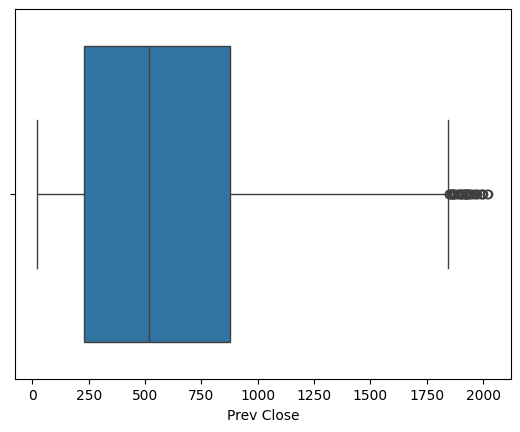

In [8]:
sns.boxplot(x=data['Prev Close'])

<Axes: xlabel='Close'>

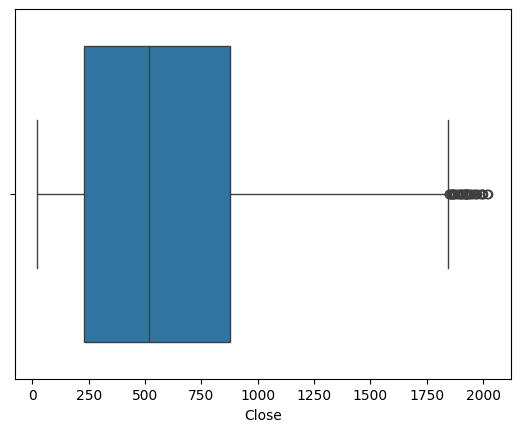

In [9]:
sns.boxplot(x=data['Close'])


In [10]:
q1 = data['Close'].quantile(0.25)
q2 = data['Close'].quantile(0.75)
iqr = q2 - q1
min_range = q1 - (1.5*iqr)
max_range = q2 + (1.5*iqr)
data = data[data['Close']<max_range]
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11


<Axes: xlabel='Close'>

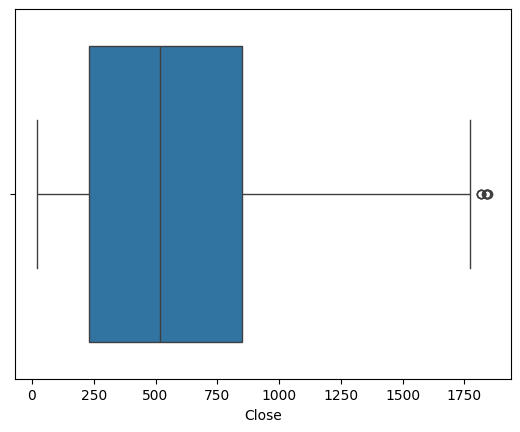

In [11]:
sns.boxplot(x=data['Close'])

In [12]:
data['Date'] = pd.to_datetime(data['Date'])


In [13]:
data.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover
0,2000-01-03,UTIBANK,EQ,24.70,26.7,26.70,26.70,26.7,26.70,26.70,112100,2.993070e+11
1,2000-01-04,UTIBANK,EQ,26.70,27.0,28.70,26.50,27.0,26.85,27.24,234500,6.387275e+11
2,2000-01-05,UTIBANK,EQ,26.85,26.0,27.75,25.50,26.4,26.30,26.24,170100,4.462980e+11
3,2000-01-06,UTIBANK,EQ,26.30,25.8,27.00,25.80,25.9,25.95,26.27,102100,2.681730e+11
4,2000-01-07,UTIBANK,EQ,25.95,25.0,26.00,24.25,25.0,24.80,25.04,62600,1.567220e+11


C:\Users\Asus\AppData\Local\Temp\ipykernel_10356\759272861.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(),annot=True,cmap="Blues")


<Axes: >

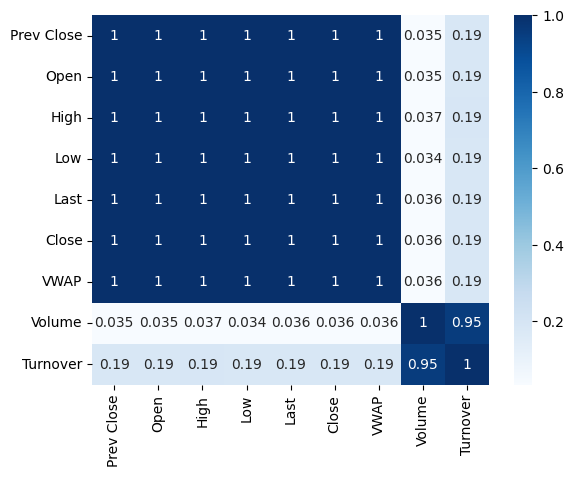

In [14]:
sns.heatmap(data.corr(),annot=True,cmap="Blues")

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


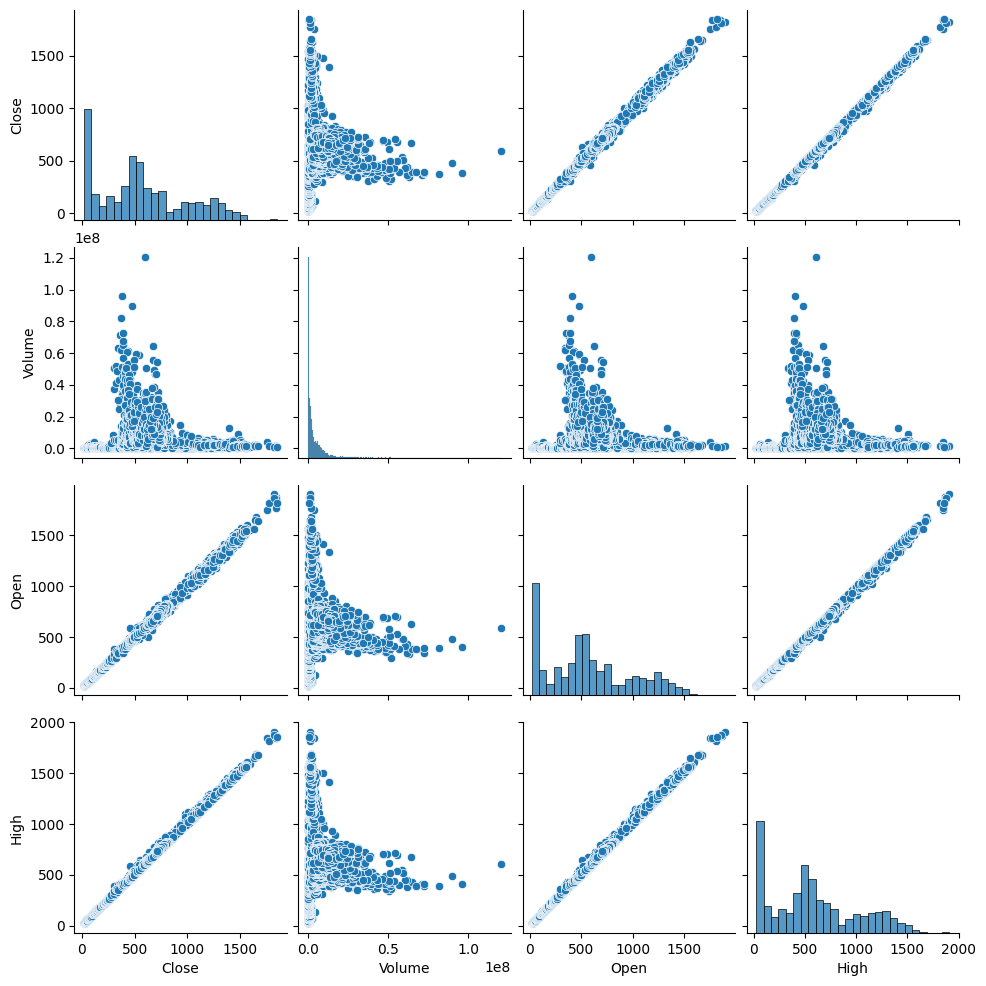

In [15]:
sns.pairplot(data[['Close', 'Volume', 'Open', 'High']])
plt.show()

### Using Linear Regression

In [ ]:
x = data[['Open','High','Low','Prev Close']]  # Last parameter
y = data['Close']

In [147]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [148]:
train_size = int(len(data)*0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_train, dates_test = data['Date'][:train_size], data['Date'][train_size:]

In [149]:
model = LinearRegression()
model.fit(x_train,y_train)

LinearRegression()

In [150]:
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

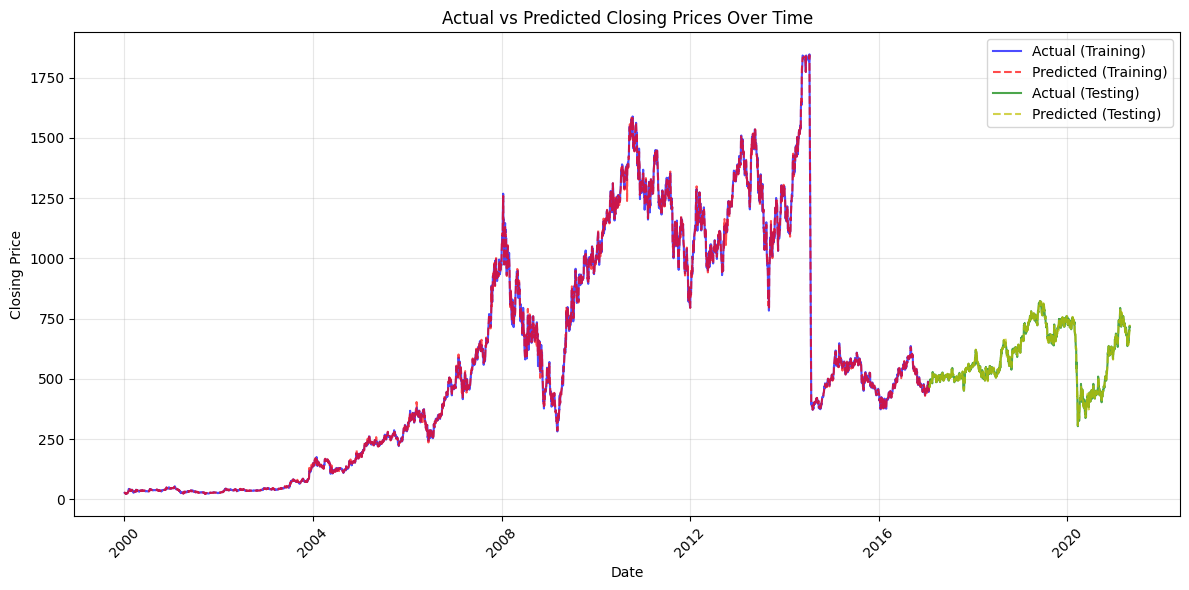

In [151]:
plt.figure(figsize=(12, 6))

plt.plot(dates_train, y_train, 'b', label='Actual (Training)', alpha=0.7)
plt.plot(dates_train, y_pred_train, 'r--', label='Predicted (Training)', alpha=0.7)

plt.plot(dates_test, y_test, 'g-', label='Actual (Testing)', alpha=0.7)
plt.plot(dates_test, y_pred_test, 'y--', label='Predicted (Testing)', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [152]:
from sklearn.metrics import mean_squared_error, r2_score
lrmse = mean_squared_error(y_test, y_pred_test)
lrrmse = np.sqrt(lrmse)
lrr2 = r2_score(y_test, y_pred_test)

print("Test Set Performance:")
print(f"Mean Squared Error: {lrmse:.2f}")
print(f"Root Mean Squared Error: {lrrmse:.2f}")
print(f"R-squared Score: {lrr2:.2f}")

Test Set Performance:
Mean Squared Error: 24.70
Root Mean Squared Error: 4.97
R-squared Score: 1.00


In [153]:
dd = {"Actual":y_test,"Predict":y_pred_test}
pd.DataFrame(dd)

,Actual,Predict
4253,472.85,475.497939
4254,471.90,473.934790
4255,466.00,465.517471
4256,475.65,471.356941
4257,482.55,481.239434
...,...,...
5301,700.45,694.012263
5302,699.55,695.340775
5303,708.15,696.311336
5304,719.40,719.361159


In [154]:
dates_train.shape,y_train.shape,y_pred_train.shape

((4212,), (4212,), (4212,))

### LSTM

In [16]:
df = data

In [17]:
df['Date'] = pd.to_datetime(df['Date'])

In [18]:
features = df[['Open', 'High', 'Low', 'Prev Close']]
target = df['Close']

In [28]:
features.shape

(5265, 4)

In [19]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

x_scaled = scaler_features.fit_transform(features)
y_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [29]:
x_scaled.shape

(5265, 4)

In [20]:
def create_sequences(x, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(x) - time_steps):
        Xs.append(x[i:(i + time_steps)])  # Creates sequences of time_steps length
        ys.append(y[i + time_steps])      # Corresponding target value
    return np.array(Xs), np.array(ys)

In [30]:
time_steps = 5
x, y = create_sequences(x_scaled, y_scaled, time_steps)
x.shape

(5260, 5, 4)

In [27]:
x.shape

(5260, 5, 4)

In [22]:
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_train = df['Date'][time_steps:train_size + time_steps]
dates_test = df['Date'][train_size + time_steps:]

In [23]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [26]:
x_train.shape

(4208, 5, 4)

In [24]:
model = Sequential([
    LSTM(50, activation='relu', input_shape=(time_steps, x_train.shape[2]), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [164]:
model.compile(optimizer=Adam(learning_rate=0.005), loss='mse')
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0301 - val_loss: 3.9993e-04
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0011 - val_loss: 1.3010e-04
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 7.3854e-04 - val_loss: 8.7857e-05
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3531e-04 - val_loss: 7.3568e-05
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.7928e-04 - val_loss: 7.4409e-05
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 5.0375e-04 - val_loss: 6.8311e-05
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.9781e-04 - val_loss: 6.9499e-05
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0010 - val_loss: 5.8616e-05
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.8406e-04 - val_loss: 6.2117e-05
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 2.0450e-04 - val_loss: 5.9792e-04
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 9.3005e-0

In [165]:
y_pred_train_scaled = model.predict(x_train)
y_pred_test_scaled = model.predict(x_test)


y_pred_train = scaler_target.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_target.inverse_transform(y_pred_test_scaled)
y_train_actual = scaler_target.inverse_transform(y_train)
y_test_actual = scaler_target.inverse_transform(y_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


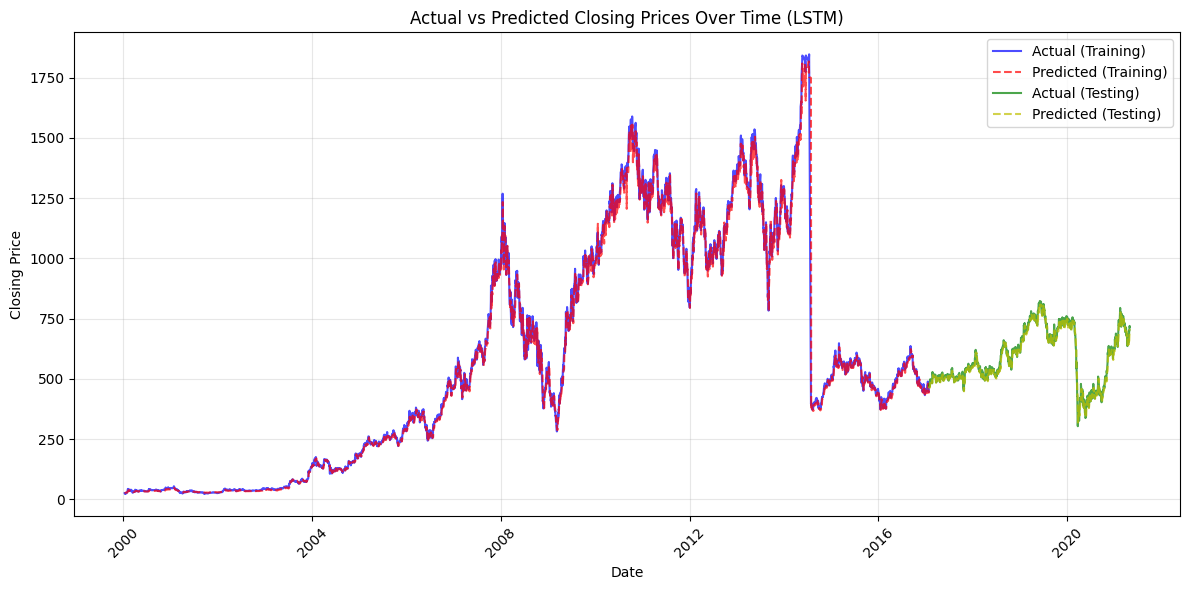

In [166]:
plt.figure(figsize=(12, 6))


plt.plot(dates_train, y_train_actual, 'b-', label='Actual (Training)', alpha=0.7)
plt.plot(dates_train, y_pred_train, 'r--', label='Predicted (Training)', alpha=0.7)


plt.plot(dates_test, y_test_actual, 'g-', label='Actual (Testing)', alpha=0.7)
plt.plot(dates_test, y_pred_test, 'y--', label='Predicted (Testing)', alpha=0.7)


plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices Over Time (LSTM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

In [167]:
lsmse = mean_squared_error(y_test_actual, y_pred_test)
lsrmse = np.sqrt(lsmse)
lsr2 = r2_score(y_test_actual, y_pred_test)

print("Test Set Performance:")
print(f"Mean Squared Error: {lsmse:.2f}")
print(f"Root Mean Squared Error: {lsrmse:.2f}")
print(f"R-squared Score: {lsr2:.2f}")



Test Set Performance:
Mean Squared Error: 267.94
Root Mean Squared Error: 16.37
R-squared Score: 0.98


### RNN

In [170]:
df = data
df['Date'] = pd.to_datetime(df['Date'])

In [171]:
features = df[['Open', 'High', 'Low', 'Prev Close']]
target = df['Close']

In [172]:
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

x_scaled = scaler_features.fit_transform(features)
y_scaled = scaler_target.fit_transform(target.values.reshape(-1, 1))

In [173]:
def create_sequences(x, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(x) - time_steps):
        Xs.append(x[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [174]:
time_steps = 10
x, y = create_sequences(x_scaled, y_scaled, time_steps)
train_size = int(len(x) * 0.8)
x_train, x_test = x[:train_size], x[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_train = df['Date'][time_steps:train_size + time_steps]
dates_test = df['Date'][train_size + time_steps:]

In [175]:
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(time_steps, x_train.shape[2]), return_sequences=True),
    SimpleRNN(50, activation='relu'),
    Dense(1)
])

C:\Users\Asus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [176]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [177]:
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0245 - val_loss: 1.7487e-04
Epoch 2/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4692e-04 - val_loss: 1.3963e-04
Epoch 3/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.3440e-04 - val_loss: 5.3532e-05
Epoch 4/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7512e-04 - val_loss: 8.5197e-05
Epoch 5/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.7776e-04 - val_loss: 4.8963e-05
Epoch 6/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8958e-04 - val_loss: 1.1461e-04
Epoch 7/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 7.0447e-04 - val_loss: 5.4339e-05
Epoch 8/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.2920e-04 - val_loss: 8.9184e-05
Epoch 9/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.6095e-04 - val_loss: 5.4246e-05
Epoch 10/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 3.0925e-04 - val_loss: 9.3461e-05
Epoch 11/50
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.

In [178]:
y_pred_train_scaled = model.predict(x_train)
y_pred_test_scaled = model.predict(x_test)

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [179]:
y_pred_train = scaler_target.inverse_transform(y_pred_train_scaled)
y_pred_test = scaler_target.inverse_transform(y_pred_test_scaled)
y_train_actual = scaler_target.inverse_transform(y_train)
y_test_actual = scaler_target.inverse_transform(y_test)

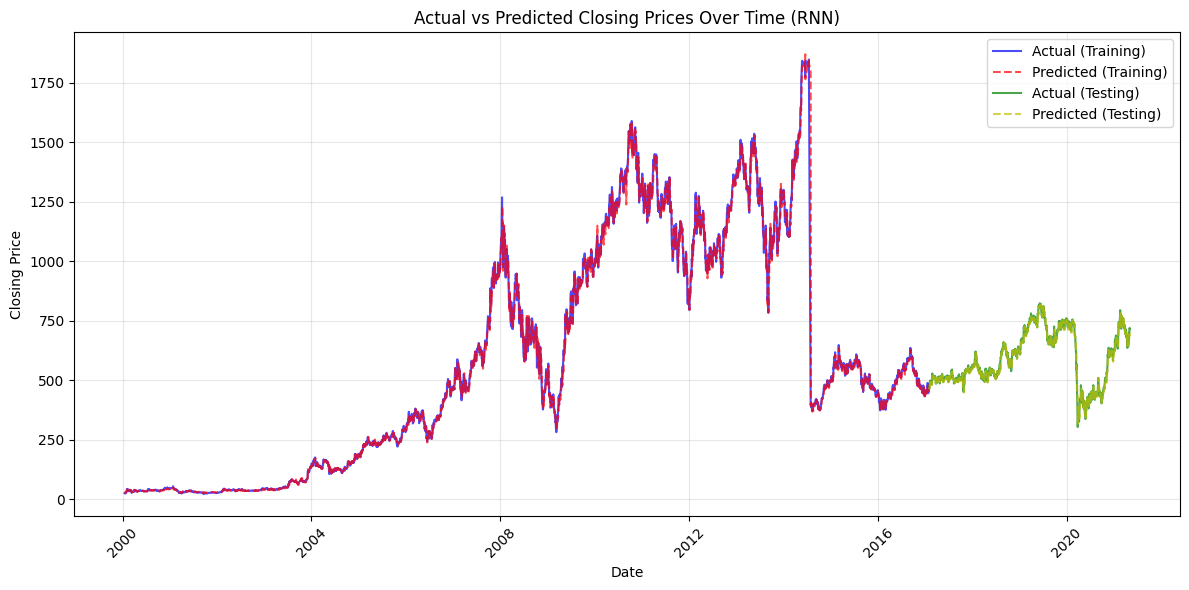

In [180]:
plt.figure(figsize=(12, 6))

plt.plot(dates_train, y_train_actual, 'b-', label='Actual (Training)', alpha=0.7)
plt.plot(dates_train, y_pred_train, 'r--', label='Predicted (Training)', alpha=0.7)

plt.plot(dates_test, y_test_actual, 'g-', label='Actual (Testing)', alpha=0.7)
plt.plot(dates_test, y_pred_test, 'y--', label='Predicted (Testing)', alpha=0.7)

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Actual vs Predicted Closing Prices Over Time (RNN)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [181]:
rnmse = mean_squared_error(y_test_actual, y_pred_test)
rnrmse = np.sqrt(rnmse)
rnr2 = r2_score(y_test_actual, y_pred_test)

print("Test Set Performance:")
print(f"Mean Squared Error: {rnmse:.2f}")
print(f"Root Mean Squared Error: {rnrmse:.2f}")
print(f"R-squared Score: {rnr2:.2f}")


Test Set Performance:
Mean Squared Error: 224.70
Root Mean Squared Error: 14.99
R-squared Score: 0.98


### SUMMARY

In [182]:
summary = {"Algorithm":["Linear Regression","Long Short-Term Memory","Recurrent Neural Network"],"MSE":[lrmse,lsmse,rnmse],"RMSE":[lrrmse,lsrmse,rnrmse],"R2 SQUARE":[lrr2,lsr2,rnr2]}
sm=pd.DataFrame(summary)
sm

,Algorithm,MSE,RMSE,R2 SQUARE
0,Linear Regression,24.696177,4.969525,0.998090
1,Long Short-Term Memory,267.941528,16.368920,0.979272
2,Recurrent Neural Network,224.698716,14.989954,0.982616
